In [4]:
# coding: utf-8
__author__ = 'Sandro Vega Pons : https://www.kaggle.com/svpons'

'''Partially based on grid_plus_classifier script:
https://www.kaggle.com/svpons/facebook-v-predicting-check-ins/grid-plus-classifier
'''

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier


def prepare_data(df, n_cell_x, n_cell_y):
    """
    Feature engineering and computation of the grid.
    """
    #Creating the grid
    size_x = 10. / n_cell_x
    size_y = 10. / n_cell_y
    eps = 0.00001  
    xs = np.where(df.x.values < eps, 0, df.x.values - eps)
    ys = np.where(df.y.values < eps, 0, df.y.values - eps)
    pos_x = (xs / size_x).astype(np.int)
    pos_y = (ys / size_y).astype(np.int)
    df['grid_cell'] = (pos_y * n_cell_x + pos_x).astype(np.int16)
    
    #Feature engineering
    fw = [500, 1000, 4, 3, 1./22., 2, 10] #feature weights (black magic here)
    df.x = df.x.values * fw[0]
    df.y = df.y.values * fw[1]
    initial_date = np.datetime64('2014-01-01T01:01', dtype='datetime64[m]') 
    d_times = pd.DatetimeIndex(initial_date + np.timedelta64(int(mn), 'm') 
                               for mn in df.time.values)    
    df['hour'] = (d_times.hour * fw[2]).astype(np.int8)
    df['weekday'] = (d_times.weekday * fw[3]).astype(np.int8)
    df['day'] = (d_times.dayofyear * fw[4]).astype(np.int8)
    df['month'] = (d_times.month * fw[5]).astype(np.int8)
    df['year'] = ((d_times.year - 2013) * fw[6]).astype(np.int8)

    df = df.drop(['time'], axis=1) 
    return df
    

def process_one_cell(df_train, df_test, grid_id, th):
    """   
    Classification inside one grid cell.
    """   
    #Working on df_train
    df_cell_train = df_train.loc[df_train.grid_cell == grid_id]
    place_counts = df_cell_train.place_id.value_counts()
    mask = (place_counts[df_cell_train.place_id.values] >= th).values
    df_cell_train = df_cell_train.loc[mask]

    #Working on df_test
    df_cell_test = df_test.loc[df_test.grid_cell == grid_id]
    row_ids = df_cell_test.index
    
    #Preparing data
    le = LabelEncoder()
    y = le.fit_transform(df_cell_train.place_id.values)
    X = df_cell_train.drop(['place_id', 'grid_cell'], axis=1).values.astype(int)
    X_test = df_cell_test.drop(['grid_cell'], axis = 1).values.astype(int)
    
    #Applying the classifier
    clf = KNeighborsClassifier(n_neighbors=25, weights='distance', 
                               metric='manhattan')
    clf.fit(X, y)
    y_pred = clf.predict_proba(X_test)
    #pred_probas = np.argsort(y_pred, axis=1)[:,::-1][:,:3]
    pred_labels = le.inverse_transform(np.argsort(y_pred, axis=1)[:,::-1][:,:3])
    
    return pred_labels, row_ids
    
    
def process_grid(df_train, df_test, th, n_cells):
    """
    Iterates over all grid cells, aggregates the results and makes the
    submission.
    """ 
    preds = np.zeros((df_test.shape[0], 3), dtype=int)
    
    for g_id in range(n_cells):
        if g_id % 100 == 0:
            print('iter: %s' %(g_id))
        
        #Applying classifier to one grid cell
        pred_labels, row_ids = process_one_cell(df_train, df_test, g_id, th)

        #Updating predictions
        preds[row_ids] = pred_labels

    print('Generating submission file ...')
    #Auxiliary dataframe with the 3 best predictions for each sample
    df_aux = pd.DataFrame(preds, dtype=str, columns=['l1', 'l2', 'l3'])  
    
    #Concatenating the 3 predictions for each sample
    ds_sub = df_aux.l1.str.cat([df_aux.l2, df_aux.l3], sep=' ')
    
    #Writting to csv
    ds_sub.name = 'place_id'
    ds_sub.to_csv('sub_grid.csv', index=True, header=True, index_label='row_id')  
      

In [3]:
"""
"""
print('Loading data ...')
df_train = pd.read_hdf('train.h5','table')
df_test = pd.read_hdf('test.h5','table')

#Defining the size of the grid
n_cell_x = 20
n_cell_y = 40 

print('Preparing train data')
#df_train = prepare_data(df_train, n_cell_x, n_cell_y)

print('Preparing test data')
#df_test = prepare_data(df_test, n_cell_x, n_cell_y)

#Solving classification problems inside each grid cell
th = 5 #Keeping place_ids with more than th samples.   
process_grid(df_train, df_test, th, n_cell_x*n_cell_y)

Loading data ...
Preparing train data
Preparing test data
iter: 0
Generating submission file ...


In [5]:
subbbb = pd.read_csv('sub_grid0.csv')

In [18]:
ii = df_test[df_test.grid_cell==0].index

In [19]:
type(ii)

pandas.indexes.numeric.Int64Index

In [20]:
subbbb.iloc[ii]

,row_id,place_id
5,5,8370753254 9727638738 4120068991
442,442,1478305117 5003921802 9727638738
2133,2133,7065354365 3642864292 8815983898
2794,2794,8958485237 1376741893 6505057624
3200,3200,5003921802 4012969260 5079685869
4345,4345,1006316884 3027578816 4180826137
4532,4532,1254758593 4895053921 7942904509
4758,4758,6138829831 6505057624 8958485237
5443,5443,6349154168 5218049605 8739476634
5991,5991,9034650629 2477372399 8944067726


In [54]:
a = pd.DataFrame(columns=list('ABC'))

In [56]:
for i in range(800):
    a = a.append({'A': df_train[df_train.grid_cell==i].shape[0], 
                  'B': df_test[df_test.grid_cell==i].shape[0],
                  'C': df_train[df_train.grid_cell==i]['place_id'].unique().shape[0]},
                  ignore_index=True)

In [57]:
a.head()

,A,B,C
0,39183.0,11290.0,912.0
1,36087.0,10345.0,1078.0
2,36259.0,12431.0,1082.0
3,33775.0,11180.0,1142.0
4,31513.0,10205.0,1209.0


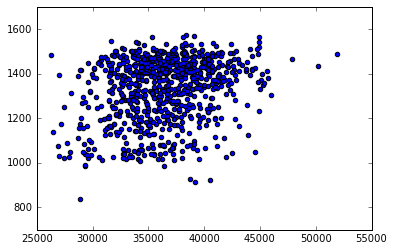

In [61]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(a['A'],a['C'])

In [48]:
29118021.0/8607230

3.382972338371346

In [64]:
a.to_hdf('gridinfo.h5','table')